# Preproces AIS data

Load data for a specific region and time period and extract trajectories of ships.

In [80]:
# imports
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd
import gym
import datetime

import os, sys

import numpy as np


from ferrygym import FerryGymEnv, Ship
from MapRevMoenk import *
from plot_helpers import plot_single_frame

/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Load data

Our AIS data is stored at a Postgres server at our institute's server.
To access the data a GraphQL API is provided through [Hasura](https://hasura.io/).


In [2]:
# connect to api
# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="http://172.23.0.4:8080/v1/graphql",
    headers={'content-type': 'application/json',
        'x-hasura-admin-secret': 'aaasdsdndsfvksdsd'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# Provide a GraphQL query
query = gql(
    """
    query MyQuery(
  $lteTimeString: String!,
  $gteTimeString: String!,
  $bound_bottom: float8!,
  $bound_top: float8!,
  $bound_left: float8!,
  $bound_right: float8!,
  $minSpeed: float8!) {
      ais(limit: 10000000, where: {
        datetime: {_lt: $lteTimeString, _gte: $gteTimeString},
        lon: {_is_null: false, _gte: $bound_left, _lte: $bound_right},
        lat: {_is_null: false, _gte: $bound_bottom, _lte: $bound_top},
        speed: {_is_null: false, _gt: $minSpeed},
        }) {
            mmsi
            datetime
            lat
            lon
            speed
            heading
            }
    }
"""
)

params = {"lteTimeString": "2022-04-07 12:00:00+00", "gteTimeString": "2022-04-01 12:00:00+00", "bound_right": BOUND_RIGHT, "bound_left": BOUND_LEFT, "bound_top": BOUND_TOP, "bound_bottom": BOUND_BOTTOM, "minSpeed": 0.3 }
print(params)

# Execute the query on the transport
result = await client.execute_async(query, variable_values=params)
df = pd.DataFrame(result['ais'])
# get min datetime in df
print('start data: ', df['datetime'].min())
# get max datetime in df
print('end date: ',df['datetime'].max())
# print min speed
print('min speed: ',df['speed'].min())
# print max speed
print('max speed: ',df['speed'].max())

{'lteTimeString': '2022-04-07 12:00:00+00', 'gteTimeString': '2022-04-01 12:00:00+00', 'bound_right': 10.190433, 'bound_left': 10.141767, 'bound_top': 54.352733, 'bound_bottom': 54.325583, 'minSpeed': 0.3}
start data:  2022-04-01 12:00:00+00
end date:  2022-04-07 11:59:56+00
min speed:  0.4
max speed:  102.3


In [3]:
# Convert in env coordinates

kwargs = dict(
    generate_training_data=True,
    data_directory='/workspace/data/rev-moenk/training/',
    df_filename='2022-04-10-13->14.pkl',
)

env = FerryGymEnv.FerryGymEnv(**kwargs)
# iterate though rows
for index, row in df.iterrows():
    # get x,y from env.convertLatonInEnvCoordinates
    x, y = env.convertLatLotInEnvCoordinates(row['lat'], row['lon'])
    # set x,y in df
    df.at[index, 'x'] = x
    df.at[index, 'y'] = y

/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# interpolate_trajectories to generate position data for every second

df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df_grouped = df.groupby(['mmsi'])
df_resampled = df_grouped.resample('1S', on='datetime').mean()
df_interpol = df_resampled.interpolate()

In [5]:
# add index column and reset index
df =  df_interpol.reset_index(level=['datetime'])
# add new index column numbering the rows
df['index'] = range(0, len(df))
df.set_index('index', inplace=True)

### Calculate speed, acceleration, direction and direction_change

In [6]:
# calculate current speed and save in new column
timedelta = datetime.timedelta(seconds=1)

df['dist_x'] = df['x'].diff().fillna(0.)
df['dist_y'] = df['y'].diff().fillna(0.)
df['dist'] = (df['dist_x']**2 + df['dist_y']**2)**0.5
# add column for speed in m/s (speed column is in knots)
speed_calculated = df['dist'] / timedelta.total_seconds()
df['speed_calculated'] = speed_calculated 
# print min speed_calculated
print('min speed_calculated: ',df['speed_calculated'].min())
# print max speed_calculated
print('max speed_calculated: ',df['speed_calculated'].max())
# count speed_calculated == 0
print('count speed_calculated == 0: ',df['speed_calculated'].eq(0).sum())



min speed_calculated:  0.0
max speed_calculated:  3471.7652814792377
count speed_calculated == 0:  4292


In [7]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['dist_x']            = df['x'].diff().fillna(0.)
df['dist_y']            = df['y'].diff().fillna(0.)
df['dist']              = (df['dist_x']**2 + df['dist_y']**2)**0.5
df['speed_calculated']  = df['dist'] / timedelta.total_seconds()
df['direction']         = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [8]:
 # calculate acceleration and save in new column
acceleration = df['speed_calculated'].diff().fillna(0.)
df['acceleration'] = acceleration / timedelta.total_seconds()
# move one row up to match state
df['acceleration'] = df['acceleration'].shift(-1)

In [9]:
import numpy as np
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['direction'] = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [10]:
# add direction_change column
df['direction_change'] = df['direction'].diff().fillna(0)
# move one row up to match state
df['direction_change'] = df['direction_change'].shift(-1)

In [11]:
# clean up first and last row in group
mask_last_row_of_ship = df.mmsi != df.mmsi.shift(-1)
# mask_time_gap = df.datetime != df.datetime.shift(1) - timedelta
df['acceleration'][mask_last_row_of_ship] = 0
df['direction_change'][mask_last_row_of_ship] = 0
mask_first_row_of_ship = df.mmsi != df.mmsi.shift(1)
df['acceleration'][mask_first_row_of_ship] = 0
df['direction_change'][mask_first_row_of_ship] = 0
df['speed_calculated'][mask_first_row_of_ship] = df['speed_calculated'].shift(1)
df['direction'][mask_first_row_of_ship] = df['direction'].shift(1)

/tmp/ipykernel_612477/4075781168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_last_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_change'][mask_last_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_first_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:8: Se

In [12]:
# round actions to 2 decimals
df['acceleration'] = df['acceleration'].round(2)
df['direction_change'] = df['direction_change'].round(2)

In [13]:
# replace nan with 0
df['acceleration'] = df['acceleration'].fillna(0)
df['direction_change'] = df['direction_change'].fillna(0)
df['speed_calculated'] = df['speed_calculated'].fillna(0)
df['direction'] = df['direction'].fillna(0)

In [14]:
def move_around_the_clock(direction_change):
    if abs(direction_change) > 180:
        if direction_change > 0:
            return direction_change - 360
        else:
            return direction_change + 360
    else:
        return direction_change

df['direction_change'] = df['direction_change'].apply(move_around_the_clock)

In [15]:
# reduce to important columns
df = df[['mmsi', 'datetime', 'x', 'y', 'speed_calculated', 'acceleration', 'direction', 'direction_change']]

In [16]:
df.describe()

,mmsi,x,y,speed_calculated,acceleration,direction,direction_change
count,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06
mean,2.286510e+08,1.225220e+03,1.507512e+03,1.664835e-01,-1.562898e-06,1.973425e+02,-1.686750e-03
std,2.538645e+07,5.665176e+02,1.280748e+03,1.420177e+00,7.883400e-02,9.075347e+01,1.983926e+00
min,2.111407e+08,1.743219e+02,0.000000e+00,0.000000e+00,-2.176000e+01,0.000000e+00,-1.800000e+02
25%,2.113248e+08,6.464050e+02,2.269204e+01,3.534664e-04,0.000000e+00,1.021056e+02,0.000000e+00
50%,2.116299e+08,1.096915e+03,1.914492e+03,1.141156e-03,0.000000e+00,2.445388e+02,0.000000e+00
75%,2.576530e+08,1.646835e+03,2.697048e+03,2.524116e-03,0.000000e+00,2.701595e+02,0.000000e+00
max,2.775040e+08,2.825311e+03,3.018942e+03,3.122505e+03,2.638000e+01,3.598309e+02,1.800000e+02


In [17]:
# group by datetime
df_grouped = df.groupby(['datetime'])
# get first group
group = df_grouped.get_group('2022-04-01T15:24:52.000Z')

In [28]:
new_gb = pd.concat( [ df_grouped.get_group(group) for i,group in enumerate( df_grouped.groups) if i < 1000 ] ).groupby('datetime')


In [29]:
def add_group_index(x):
    # for each row in group add index
    x['group_index'] = range(0, len(x))
    return x

groups = new_gb.apply(add_group_index)

/tmp/ipykernel_612477/27796813.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  groups = new_gb.apply(add_group_index)


In [30]:

groups.describe()

,mmsi,x,y,speed_calculated,acceleration,direction,direction_change,group_index
count,4.971000e+03,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000
mean,2.179709e+08,1010.410219,2028.307853,1.420752,-0.002529,128.730680,-0.099851,2.188896
std,1.603438e+07,364.902919,516.070312,2.029572,0.231857,98.945993,8.233177,1.650415
min,2.112231e+08,587.963833,12.564922,0.000000,-6.080000,0.000000,-180.000000,0.000000
25%,2.113913e+08,774.440340,1911.066487,0.002771,0.000000,38.931853,0.000000,1.000000
50%,2.114582e+08,881.360944,2171.970502,0.023071,0.000000,99.210515,0.000000,2.000000
75%,2.116299e+08,1055.927359,2275.462653,3.418837,0.000000,179.381733,0.000000,4.000000
max,2.571820e+08,2368.159940,2987.362899,7.890813,4.460000,345.162797,180.000000,5.000000


In [32]:
# get row where group_index == 5
groups[groups['group_index'] == 5]

,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change,group_index
index,,,,,,,,,
6157848,257182000.0,2022-04-01 12:07:20+00:00,1020.787645,2453.193591,4.499273,0.0,39.326476,0.0,5
6157849,257182000.0,2022-04-01 12:07:21+00:00,1023.639007,2449.713190,4.499273,-0.0,39.326476,-0.0,5
6157850,257182000.0,2022-04-01 12:07:22+00:00,1026.490369,2446.232789,4.499273,-0.0,39.326476,0.0,5
6157851,257182000.0,2022-04-01 12:07:23+00:00,1029.341731,2442.752388,4.499273,0.0,39.326476,-0.0,5
6157852,257182000.0,2022-04-01 12:07:24+00:00,1032.193093,2439.271986,4.499273,0.0,39.326476,0.0,5
...,...,...,...,...,...,...,...,...,...
6158403,257182000.0,2022-04-01 12:16:35+00:00,1699.160895,12.564928,0.000819,-0.0,270.100319,0.0,5
6158404,257182000.0,2022-04-01 12:16:36+00:00,1699.160076,12.564926,0.000819,0.0,270.100319,-0.0,5
6158405,257182000.0,2022-04-01 12:16:37+00:00,1699.159256,12.564925,0.000819,0.0,270.100319,0.0,5


In [36]:
group = groups.groupby('datetime').get_group('2022-04-01 12:07:22+00:00')
group

,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change,group_index
index,,,,,,,,,
1450350,211223120.0,2022-04-01 12:07:22+00:00,774.700280,2170.080188,0.011394,0.0,270.000000,0.0,0
3085193,211391280.0,2022-04-01 12:07:22+00:00,1054.774153,1543.532359,0.023071,-0.0,140.456096,0.0,1
3157410,211399920.0,2022-04-01 12:07:22+00:00,684.798014,2618.280701,0.261782,-0.0,90.683641,-0.0,2
3722752,211458210.0,2022-04-01 12:07:22+00:00,749.598732,2217.044832,0.007256,-0.0,7.659794,-0.0,3
4277154,211629870.0,2022-04-01 12:07:22+00:00,883.063876,1911.746665,0.007760,0.0,288.940924,0.0,4
6157850,257182000.0,2022-04-01 12:07:22+00:00,1026.490369,2446.232789,4.499273,-0.0,39.326476,0.0,5


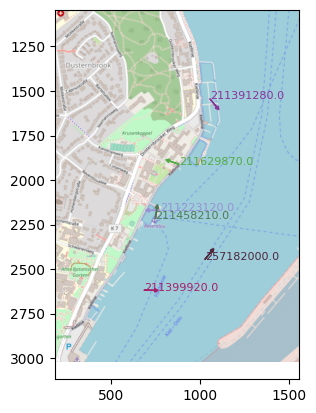

In [116]:
plot_single_frame(group)



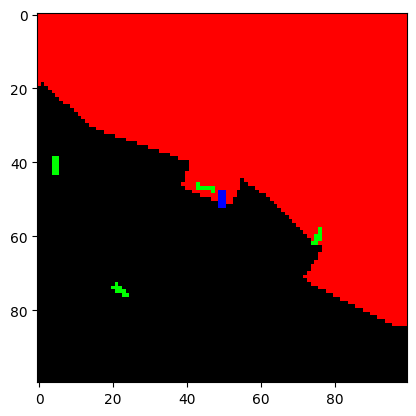

In [123]:
# create ship object for every row in group
ships = []
for index, row in group.iterrows():
    ship = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
    ships.append(ship)

first_row = group.iloc[0]
agent = Ship.Ship((first_row['x'], first_row['y']), first_row['direction'], 1, first_row['mmsi'])
# render neighborhood
neighborhood = env.render_neighborhood(agent, ships)
# plot neighborhood
# turn image 90 degrees right
neighborhood = np.rot90(neighborhood, 3)
# mirror image
neighborhood = np.fliplr(neighborhood)
plt.imshow(neighborhood)

In [107]:
agent.direction

270.0

In [108]:
agent.mmsi

211223120.0

In [24]:
df_test = pd.DataFrame({'A': 'a a b'.split(), 'B': [1,2,3], 'C': [4,6, 5]})
g = df_test.groupby('A')
g

In [27]:
def func(x):
    print(x)
    return x / x.sum()

g.apply(func)

   A  B  C
0  a  1  4
1  a  2  6
   B  C
0  1  4
1  2  6
   B  C
2  3  5


/tmp/ipykernel_576447/2205578623.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  g.apply(func)


,B,C
0,0.333333,0.4
1,0.666667,0.6
2,1.000000,1.0


In [ ]:
# apply function to member of group

In [42]:
# save df to pickle file
print('Saving df to pickle file')
df.to_pickle('/workspace/data/2022-04-01-12->04-07-12.pkl')

In [4]:
### Generate neighborhood images

kwargs = dict(
    generate_training_data=True,
    data_directory='/workspace/data/rev-moenk3/training/',
    df_filename='2022-04-01-12->04-07-12.pkl',
    startingTime=datetime.datetime(2022, 4, 1, 12, 0, 1),
)

gym.register(
    id="FerryGym-preprocess-v1",
    entry_point="FerryGymEnv.FerryGymEnv:FerryGymEnv",
    kwargs=kwargs,
)

env = gym.make('FerryGym-preprocess-v1')

print('start generating images, this may take a while')
env.reset()
done = False
# for step in range(1):
while not done:
    obs, reward, done, info = env.step((1, 1))
    if done:
        env.close()
        break



/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment FerryGym-preprocess-v1
  logger.warn(f"Overriding environment {spec.id}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one boo

reset called
stop at:  2022-04-10 14:00:01
saving df:  /workspace/data/rev-moenk/training/df_2022-04-10 13:00:01.pkl
